In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pickle
import os


In [ ]:

import pandas as pd
#from behav import fix_position_resets, compute_time2pos, distributions_t2p, compare_to_distrib
from src.features.features import fix_position_resets, compute_time2pos, distributions_t2p, compare_to_distrib

FR = 60

def generate_key_events(var, key, FR=60):
    '''
    var = action variable, directly from allvars dict
    '''
    var_bin = [int(val) for val in var]
    diffs = list(np.diff(var_bin, n=1))
    presses = [round(i/FR, 3) for i, x in enumerate(diffs) if x == 1]
    releases = [round(i/FR, 3) for i, x in enumerate(diffs) if x == -1]
    onset = presses
    duration = [round(releases[i] - presses[i], 3) for i in range(len(presses))]
    trial_type = [key for i in range(len(presses))]
    events_df = pd.DataFrame(data={'onset':onset,
                                   'duration':duration,
                                   'trial_type':trial_type})
    return events_df

def generate_relspeed_events(var, FR=60, split_size=0.2, min_dur=1):
    '''
    var = list of pos_percentiles obtained with behav.compare_to_distrib()
    '''
    mask_IN = np.zeros(len(var))
    mask_OUT = np.zeros(len(var))

    for i, timestep in enumerate(var[1:-1]): # always keep the first and last value as 0 so diff will register the state transition
        if timestep/100 <= split_size:
            mask_IN[i+1] = 1
        if timestep/100 >= 1-split_size:
            mask_OUT[i+1] = 1

    diff_IN = np.diff(mask_IN, n=1)
    diff_OUT = np.diff(mask_OUT, n=1)

    durations_IN = np.array([i for i, x in enumerate(diff_IN) if x == -1]) - np.array([i for i, x in enumerate(diff_IN) if x == 1])
    durations_OUT = np.array([i for i, x in enumerate(diff_OUT) if x == -1]) - np.array([i for i, x in enumerate(diff_OUT) if x == 1])
    
    #build df
    onset = []
    duration = []
    trial_type = []
    for i, dur in enumerate(durations_IN):
        if dur >= (min_dur*FS):
            onset.append(np.array([i for i, x in enumerate(diff_IN) if x == 1])[i]/FR)
            duration.append(durations_IN[i]/FR)
            trial_type.append('good_perf')
    for i, dur in enumerate(durations_OUT):
        if dur >= (min_dur*FS):
            onset.append(np.array([i for i, x in enumerate(diff_OUT) if x == 1])[i]/FR)
            duration.append(durations_OUT[i]/FR)
            trial_type.append('bad_perf')

    events_df = pd.DataFrame(data={'onset':onset,
                                   'duration':duration,
                                   'trial_type':trial_type})
    return events_df
    
def generate_aps_events():
    return events_df

In [9]:
from src.data.data import combine_variables, remove_fake_reps
import numpy as np

level = '1'
subj = 'sub-06'
path_to_data = '/home/hyruuk/GitHub/neuromod/hyruuk_shinobi_behav/data'
repetition = 0

# parameters
split_size = 0.2
min_dur = 1
FS = 60

allvars = combine_variables(path_to_data, subj, level)
allvars = remove_fake_reps(allvars)

# init df list
all_df = []

# get the different possible actions
actions = list(allvars.keys())[2:14]
# generate events for each of them
for act in actions:
    var = allvars[act][repetition]
    all_df.append(generate_key_events(var, act, FR=FR))


# get the 
X_player_lists = fix_position_resets(allvars['X_player'])
time2pos_lists = compute_time2pos(X_player_lists)
distrib_t2p = distributions_t2p(time2pos_lists)
rel_speed = []
for run in time2pos_lists:
    rel_speed.append(compare_to_distrib(distrib_t2p, run))
# generate events
all_df.append(generate_relspeed_events(rel_speed[repetition], FR=FR, split_size=split_size, min_dur=min_dur))


# Merge all dfs
merged_df = pd.concat(all_df).sort_values(by='onset').reset_index(drop=True)

In [10]:
merged_df

,onset,duration,trial_type
0,0.150,98.366667,bad_perf
1,1.667,0.266000,RIGHT
2,2.450,0.267000,UP
3,3.100,0.233000,DOWN
4,3.783,0.484000,DOWN
...,...,...,...
320,200.800,0.350000,RIGHT
321,201.117,0.283000,UP
322,203.500,0.150000,B
323,203.717,0.150000,B


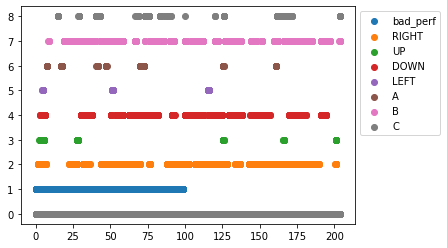

In [68]:
import matplotlib.pyplot as plt

event_ends = []
for i in range(len(merged_df['onset'])):
    event_ends.append(merged_df['onset'][i] + merged_df['duration'][i])
    
total_duration = max(event_ends)
time_axis = np.linspace(0, total_duration, 10000)


dict_to_plot = {}
for ev_type in merged_df['trial_type'].unique():
    dict_to_plot[ev_type] = np.zeros(len(time_axis))

for idx, line in merged_df.iterrows():
    for i, timepoint in enumerate(time_axis):
        if timepoint >= line['onset'] and timepoint <= line['onset']+line['duration']:
            dict_to_plot[line['trial_type']][i] = 1

for i, key in enumerate(dict_to_plot.keys()):
    plt.scatter(time_axis, dict_to_plot[key]*(i+1), label=key)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

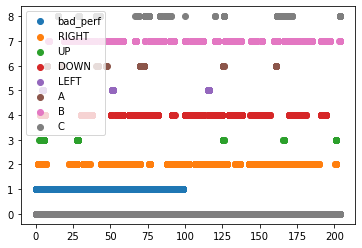

In [62]:
for i, key in enumerate(dict_to_plot.keys()):
    plt.scatter(time_axis, dict_to_plot[key]*(i+1), label=key)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [ ]:
def plot_bidsevents(events_df):
    return fig

In [41]:
for idx, line in merged_df.iterrows():
    print(line)

onset             0.15
duration       98.3667
trial_type    bad_perf
Name: 0, dtype: object
onset         1.667
duration      0.266
trial_type    RIGHT
Name: 1, dtype: object
onset          2.45
duration      0.267
trial_type       UP
Name: 2, dtype: object
onset           3.1
duration      0.233
trial_type     DOWN
Name: 3, dtype: object
onset         3.783
duration      0.484
trial_type     DOWN
Name: 4, dtype: object
onset         4.45
duration      0.35
trial_type    LEFT
Name: 5, dtype: object
onset          4.95
duration      0.283
trial_type    RIGHT
Name: 6, dtype: object
onset         5.533
duration       0.25
trial_type       UP
Name: 7, dtype: object
onset         5.967
duration       0.15
trial_type     DOWN
Name: 8, dtype: object
onset           6.3
duration      0.283
trial_type    RIGHT
Name: 9, dtype: object
onset         7.35
duration      0.35
trial_type       A
Name: 10, dtype: object
onset         8.5
duration      0.1
trial_type      B
Name: 11, dtype: object
onset

In [49]:
dict_to_plot

{'bad_perf': array([0., 0., 0., ..., 0., 0., 0.]),
 'RIGHT': array([0., 0., 0., ..., 0., 0., 0.]),
 'UP': array([0., 0., 0., ..., 0., 0., 0.]),
 'DOWN': array([0., 0., 0., ..., 0., 0., 0.]),
 'LEFT': array([0., 0., 0., ..., 0., 0., 0.]),
 'A': array([0., 0., 0., ..., 0., 0., 0.]),
 'B': array([0., 0., 0., ..., 0., 0., 0.]),
 'C': array([0., 0., 0., ..., 1., 1., 1.])}

In [65]:

np.nan()

TypeError: 'float' object is not callable

In [ ]:
from behav import remove_fake_reps
allvars_clean = remove_fake_reps(allvars)

In [ ]:
from behav import retrieve_variables
testfile = '/home/hyruuk/GitHub/neuromod/shinobi_data/sub02/5-0/ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level5-0_p02_1599948075.bk2'
variables_lists = retrieve_variables([testfile], '1-0')

In [3]:
!pip install pandas

     |████████████████████████████████| 9.3 MB 2.8 MB/s eta 0:00:01


In [ ]:
actions = list(allvars.keys())[2:14]

In [ ]:
'''
var = list of pos_percentiles obtained with behav.compare_to_distrib()
'''
mask_IN = np.zeros(len(var))
mask_OUT = np.zeros(len(var))

for i, timestep in enumerate(var[1:-1]): # always keep the first and last value as 0 so diff will register the state transition
    if timestep/100 <= split_size:
        mask_IN[i+1] = 1
    if timestep/100 >= 1-split_size:
        mask_OUT[i+1] = 1

diff_IN = np.diff(mask_IN, n=1)
diff_OUT = np.diff(mask_OUT, n=1)

durations_IN = np.array([i for i, x in enumerate(diff_IN) if x == -1]) - np.array([i for i, x in enumerate(diff_IN) if x == 1])
durations_OUT = np.array([i for i, x in enumerate(diff_OUT) if x == -1]) - np.array([i for i, x in enumerate(diff_OUT) if x == 1])

#build df
onset = []
duration = []
trial_type = []
for i, dur in enumerate(durations_IN):
    if dur >= (min_dur*FS):
        onset.append(np.array([i for i, x in enumerate(diff_IN) if x == 1])[i]/FR)
        duration.append(durations_IN[i]/FR)
        trial_type.append('good_perf')
for i, dur in enumerate(durations_OUT):
    if dur >= (min_dur*FS):
        onset.append(np.array([i for i, x in enumerate(diff_OUT) if x == 1])[i]/FR)
        duration.append(durations_OUT[i]/FR)
        trial_type.append('bad_perf')

events_df = pd.DataFrame(data={'onset':onset,
                               'duration':duration,
                               'trial_type':trial_type})

In [ ]:
indices_IN = [i for i, x in enumerate(diff_IN) if x == -1]
indices_OUT = [i for i, x in enumerate(diff_OUT) if x == -1]
plt.plot(var)

In [ ]:
### TODO :
## Either rel speed on derivative of rel speed


X_player_lists = fix_position_resets(allvars['X_player'])
time2pos_lists = compute_time2pos(X_player_lists)
distrib_t2p = distributions_t2p(time2pos_lists)
instant_perfs = []
for run in time2pos_lists:
    instant_perfs.append(compare_to_distrib(distrib_t2p, run))


'''
onset = presses
duration = [round(releases[i] - presses[i], 3) for i in range(len(presses))]
trial_type = [key for i in range(len(onset))]
events_df = pd.DataFrame(data={'onset':onset,
                               'duration':duration,
                               'trial_type':trial_type})
'''

In [ ]:
### Copy correct files in a folder
import shutil
for filename in usable_filenames_all['sub01_1-0']:
    shutil.copyfile(filename, '/home/hyruuk/GitHub/neuromod/shinobi_data/data_ani/' + filename[52:])

## time2pos

In [ ]:
### compute percentile and plot
pos_percentile = compare_to_distrib(distrib_t2p, time2pos_lists[-69])
plt.plot(pos_percentile)



In [ ]:
from scipy import signal
import numpy as np

# plot individual run against distrib of all runs
pos_percentile = compare_to_distrib(distrib_t2p, time2pos_lists[-69])
plt.plot(pos_percentile)

# same but filtered
b, a = signal.butter(3,0.005)
pos_filtered = signal.filtfilt(b, a, pos_percentile)
plt.plot(pos_filtered)

# same but differentiated, in order to get "instantaneous" performance
pos_derived = np.diff(pos_filtered, n=1)
plt.plot(pos_derived)

# Deprecated


All these functions were used troughout the development of this notebook but are useless/replaced since.
I saved them here for posterity
(... or in case I need to get back to them for some reason.)

In [ ]:
### load the files and extract the variable
def retrieve_variable(files, variable):
    '''
    files : list of files with complete path
    variable : name of variable to get
    
    variable_lists : list of arrays of length corresponding to the number of frames in each run
    '''
    env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level'+level)
    variable_lists = []
    for file in files:
        variable_list = []
        key_log = retro.Movie(file)
        env.reset()
        while key_log.step():
            a = [key_log.get_key(i, 0) for i in range(env.num_buttons)]
            _,_,_,i = env.step(a)
            variable_list.append(i[variable])
        variable_lists.append(variable_list)
    return variable_lists

def retrieve_X_player_lists(files):
    
    env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level'+level)
    
    X_player_lists = []

    for file in files:

        X_player_list = []

        key_log = retro.Movie(file)

        env.reset()

        while key_log.step():

            a = [key_log.get_key(i, 0) for i in range(env.num_buttons)]
            _,_,_,i = env.step(a)

            X_player_list.append(i['X_player'])

        X_player_lists.append(X_player_list)
        
    return X_player_lists

def save_X_player_list(subject, level, path_to_data):
    files = sorted(glob(path_to_data + subject + '/' + level + '/ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level' + level + '*'))
    X_player_lists = retrieve_X_player_lists(files)
    X_player_lists = fix_position_resets(X_player_lists)
    X_lists_path = op.join(path_to_data, '{}_{}_X_player.mat'.format(subject, level))
    with open(X_lists_path, 'wb') as f:
        pickle.dump(X_player_lists, f)
    
def load_X_player_list(subject, level, path_to_data):
    X_lists_path = op.join(path_to_data, '{}_{}_X_player.mat'.format(subject, level))
    with open(X_lists_path, 'rb') as f:
        X_player_lists = pickle.load(f)
    return X_player_lists
    
def fit_and_retrieve_coefficients(X_player_lists):
    
    coef_X_player_lists = []
    
    for X_player_list in X_player_lists:
        
        x = np.arange(len(X_player_list)).reshape(-1, 1)
        y = np.array(X_player_list).reshape(-1, 1)
        
        reg = LinearRegression().fit(x,y)
        coef = reg.coef_
        
        coef_X_player_lists.append(float(coef))
        
    return coef_X_player_lists

def compute_moving_variance(coef_X_player_lists):
    
    moving_variance = []
    
    for i in range(len(coef_X_player_lists)-9):
        moving_variance.append(np.var(coef_X_player_lists[i:i+10]))
        
    return moving_variance

def print_lists_and_corresponding_files(files, lists):
    
    for i in range( len(files) ):
        print(lists[i],'\n', files[i],'\n\n')

X_player_lists = retrieve_X_player_lists(files)
X_player_lists = fix_position_resets(X_player_lists)
coef_X_player_lists = fit_and_retrieve_coefficients(X_player_lists)
moving_variance = compute_moving_variance(coef_X_player_lists)
plt.plot(moving_variance)

